## Verify "Smooth Adversarial Training" paper

Procedures:
1. Images dataset uses MNIST
2. Creates two models (using ReLU activation function and smooth ReLU activation function)
3. Creates adversarial examples by FGSM for training set (epsilon=0.05)
4. Creates adversarial examples by FGSM  for test set (epsilon=0.15)
5. Two models train with the adversarial examples
6. Evaluation

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
import numpy as np
import random
import matplotlib.pyplot as plt
from keras import backend as K

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
x_train.shape

(60000, 28, 28)

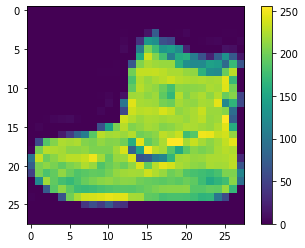

In [4]:
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [5]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [6]:
img_rows, img_cols, channels = 28, 28, 1
num_classes = 10

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

Data shapes (10000, 28, 28, 1) (10000, 10) (60000, 28, 28, 1) (60000, 10)


In [7]:
def create_model(function):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation=function, input_shape=(img_rows, img_cols, channels)))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation=function))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation=function))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(32))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return model

In [8]:
def smoothrelu(x, beta=10):
    return K.relu(x - (1./beta) * tf.math.log(tf.abs(x) * beta + 1.))

In [9]:
model_relu = create_model('relu')
model_smoothrelu = create_model(smoothrelu)

In [10]:
def model_train(model,x_train,y_train,x_test,y_test):
    model.fit(x_train, y_train,
              batch_size=32,
              epochs=5,
              validation_data=(x_test, y_test))
    return model

In [11]:
model_train_relu = model_train(model_relu,x_train,y_train,x_test,y_test)
model_train_smoothrelu = model_train(model_smoothrelu,x_train,y_train,x_test,y_test)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 11s 176us/sample - loss: 0.0335 - accuracy: 0.7620 - val_loss: 0.0235 - val_accuracy: 0.8354
Epoch 2/5
60000/60000 [==============================] - 10s 165us/sample - loss: 0.0232 - accuracy: 0.8409 - val_loss: 0.0206 - val_accuracy: 0.8607
Epoch 3/5
60000/60000 [==============================] - 10s 166us/sample - loss: 0.0207 - accuracy: 0.8585 - val_loss: 0.0194 - val_accuracy: 0.8678
Epoch 4/5
60000/60000 [==============================] - 10s 165us/sample - loss: 0.0192 - accuracy: 0.8694 - val_loss: 0.0185 - val_accuracy: 0.8741
Epoch 5/5
60000/60000 [==============================] - 10s 166us/sample - loss: 0.0181 - accuracy: 0.8765 - val_loss: 0.0179 - val_accuracy: 0.8770
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 13s 223us/sample - loss: 0.0368 - accuracy: 0.7370 - val_loss: 0.0239 - val_accuracy: 0.8336


In [12]:
def model_evaluate(model,x_test,y_test):
    score = model.evaluate(x=x_test, y=y_test, verbose=0)
    return score[1]

In [13]:
print("Accuracy of model with ReLU on regular images:", model_evaluate(model_train_relu,x_test,y_test))
print("Accuracy of model with Smooth ReLU on regular images:", model_evaluate(model_train_smoothrelu,x_test,y_test))

Accuracy of model with ReLU on regular images: 0.877
Accuracy of model with Smooth ReLU on regular images: 0.875


In [14]:
def adversarial_pattern(image, label, model):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

In [15]:
image = x_train[0]

In [16]:
image_label = y_train[0]

In [17]:
perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label,model_train_relu).numpy()

In [18]:
adversarial = image + perturbations * 0.05

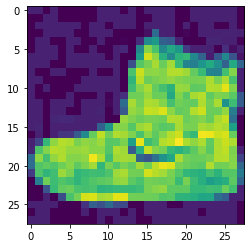

In [19]:
if channels == 1:
    plt.imshow(adversarial.reshape((img_rows, img_cols)))
else:
    plt.imshow(adversarial.reshape((img_rows, img_cols, channels)))
plt.show()

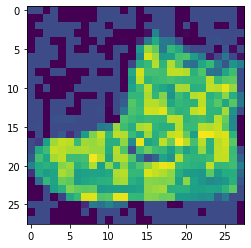

In [20]:
perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label,model_train_relu).numpy()
adversarial = image + perturbations * 0.15
if channels == 1:
    plt.imshow(adversarial.reshape((img_rows, img_cols)))
else:
    plt.imshow(adversarial.reshape((img_rows, img_cols, channels)))
plt.show()

In [21]:
def generate_adversarials(batch_size,epsilon,model):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 100)

            label = y_train[N]
            image = x_train[N]
            
            perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label,model).numpy()
            adversarial = image + perturbations * epsilon
            
            x.append(adversarial)
            y.append(y_train[N])
        
        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y)
        
        yield x, y

In [22]:
x_adversarial_test_relu, y_adversarial_test_relu = next(generate_adversarials(1000,0.15,model_train_relu))

In [23]:
x_adversarial_test_smoothrelu, y_adversarial_test_smoothrelu = next(generate_adversarials(1000,0.15,model_train_smoothrelu))

In [24]:
x_adversarial_train_relu, y_adversarial_train_relu = next(generate_adversarials(3000,0.05,model_train_relu))

In [25]:
x_adversarial_train_smoothrelu, y_adversarial_train_smoothrelu = next(generate_adversarials(3000,0.05,model_train_smoothrelu))

In [26]:
new_model_relu = model_train(model_relu,x_adversarial_train_relu,y_adversarial_train_relu,
                         x_adversarial_test_relu,y_adversarial_test_relu)

Train on 3000 samples, validate on 1000 samples
Epoch 1/5
3000/3000 [==============================] - 1s 178us/sample - loss: 0.0027 - accuracy: 0.9860 - val_loss: 0.0439 - val_accuracy: 0.7180
Epoch 2/5
3000/3000 [==============================] - 1s 171us/sample - loss: 0.0028 - accuracy: 0.9853 - val_loss: 0.0379 - val_accuracy: 0.7610
Epoch 3/5
3000/3000 [==============================] - 1s 177us/sample - loss: 0.0027 - accuracy: 0.9860 - val_loss: 0.0409 - val_accuracy: 0.7500
Epoch 4/5
3000/3000 [==============================] - 1s 194us/sample - loss: 0.0026 - accuracy: 0.9860 - val_loss: 0.0300 - val_accuracy: 0.7770
Epoch 5/5
3000/3000 [==============================] - 1s 209us/sample - loss: 0.0017 - accuracy: 0.9890 - val_loss: 0.0350 - val_accuracy: 0.7490


In [27]:
print("Accuracy of model with ReLU on adversarial examples:", 
      model_evaluate(new_model_relu, x_adversarial_test_relu,y_adversarial_test_relu))

Accuracy of model with ReLU on adversarial examples: 0.749


In [28]:
new_model_smoothrelu = model_train(model_smoothrelu,x_adversarial_train_smoothrelu,y_adversarial_train_smoothrelu,
                               x_adversarial_test_smoothrelu,y_adversarial_test_smoothrelu)

Train on 3000 samples, validate on 1000 samples
Epoch 1/5
3000/3000 [==============================] - 1s 235us/sample - loss: 0.0018 - accuracy: 0.9893 - val_loss: 0.0274 - val_accuracy: 0.8050
Epoch 2/5
3000/3000 [==============================] - 1s 233us/sample - loss: 7.5161e-04 - accuracy: 0.9970 - val_loss: 0.0241 - val_accuracy: 0.8370
Epoch 3/5
3000/3000 [==============================] - 1s 234us/sample - loss: 7.3993e-04 - accuracy: 0.9953 - val_loss: 0.0226 - val_accuracy: 0.8630
Epoch 4/5
3000/3000 [==============================] - 1s 237us/sample - loss: 5.2418e-04 - accuracy: 0.9983 - val_loss: 0.0203 - val_accuracy: 0.8550
Epoch 5/5
3000/3000 [==============================] - 1s 233us/sample - loss: 3.9908e-04 - accuracy: 0.9983 - val_loss: 0.0150 - val_accuracy: 0.8860


In [29]:
print("Accuracy of model with Smooth ReLU on adversarial examples:", 
      model_evaluate(new_model_smoothrelu, x_adversarial_test_smoothrelu,y_adversarial_test_smoothrelu))

Accuracy of model with Smooth ReLU on adversarial examples: 0.886
